In [1]:
import torch
import torchvision.datasets

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

batch_size = 64
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

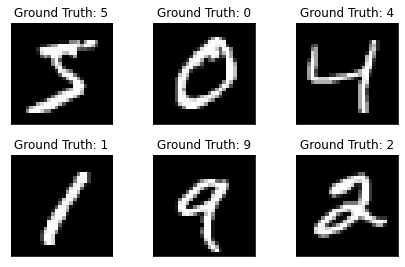

In [12]:
import matplotlib.pyplot as plt

label = train_data.targets.detach().numpy()
data = train_data.data.detach().numpy()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])


In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

## ネットワークの作成

簡単なConvolusion networkを作る。

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [15]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [24]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [25]:
def test(loader, label, accuracy_list):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  if label == "Test":
    test_losses.append(test_loss)
  acc = 100. * correct / len(loader.dataset)
  print('\n {} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    label, test_loss, correct, len(loader.dataset),
    acc))
  accuracy_list.append(acc)

In [27]:
train_losses = []
train_counter = []
train_acc = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []


In [28]:
test(train_loader, 'Train', train_acc)
test(test_loader, 'Test', test_acc)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test(train_loader, 'Train', train_acc)
  test(test_loader, 'Test', test_acc)

<ipython-input-14-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



 Train set: Avg. loss: 0.0854, Accuracy: 58447/60000 (97%)

 Test set: Avg. loss: 0.0770, Accuracy: 9761/10000 (98%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.269006
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.211010
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.365203
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.136850
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.205354
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.380492
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.141548
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.230977
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.138049
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.406837
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.145708
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.375790
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.184930
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.242972
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.348382
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.219021
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.476187
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.306232
Train Epoch

Text(0, 0.5, 'negative log likelihood loss')

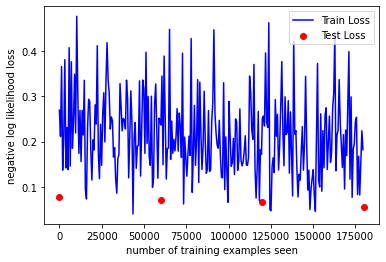

In [29]:
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

(80.0, 100.0)

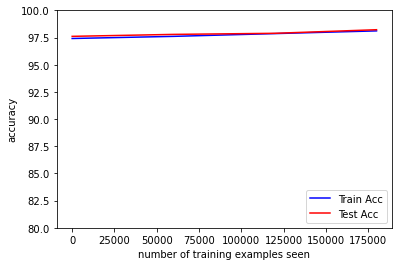

In [30]:
plt.plot(test_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, color='red')
plt.legend(['Train Acc', 'Test Acc'], loc='lower right')
plt.xlabel('number of training examples seen')
plt.ylabel('accuracy')
plt.ylim(80, 100)

In [31]:
test_acc, train_acc


([tensor(97.6100), tensor(97.7900), tensor(97.8900), tensor(98.2200)],
 [tensor(97.4117), tensor(97.6083), tensor(97.8633), tensor(98.1117)])

In [32]:
train_acc

[tensor(97.4117), tensor(97.6083), tensor(97.8633), tensor(98.1117)]